In [1]:
''' 

Submitter : JESOON KANG, 20170937
Date : 2019. 10. 


    Assignment 4. 

-   -


'''
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torchvision
import os


In [2]:

#### Section 1. #### This Section is bringed Data_import_ex.py file.

# Image Data import & resize

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = '../data/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)  


validation_data_path = '../data/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True, num_workers=0)  

#### Section 1 END ####


In [3]:

# sigmoid Function.
def sigmoid(z) :
    return 1 / (1 + torch.pow(math.e,-z)+0.000001)

def tanh(z) :
    ret = (2 / (1 + torch.pow(math.e,-2*z) + 0.000001)) - 1
    return ret

def derv_tanh(z) :
    ret = (1 - (tanh(z)**2))
    return ret

def relu(z) :
    ret = z.clone().detach()
    #print(ret)
    tmp = torch.zeros_like(ret)
    ret = torch.where(ret<=0,tmp,ret)
    return ret
                                                                  
def derv_relu(z) :
    ret = z.clone().detach()
    tmp_1 = torch.zeros_like(ret)
    tmp_2 = torch.ones_like(ret)
    ret = torch.where(ret<0,tmp_1,tmp_2)
    #print(ret)
    return ret
    
            
def leakly_relu(z) :
    ret = z.clone().detach()
    tmp1 = torch.ones_like(ret)
    ret = torch.where(ret<0,ret*0.01,ret)
    return ret

def derv_leakly_relu(z) :
    ret = z.clone().detach()
    tmp1 = torch.ones_like(ret)
    ret = torch.where(ret<0, tmp1*0.01,tmp1)
    
    return ret

def get_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)
    elif (type == 1) :
        return tanh(z)
    elif (type == 2) :
        return relu(z)
    elif (type == 3) :
        return leakly_relu(z)
    
    else :
        print("Error, get_activation")
        return 0

def get_derv_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)*(1-sigmoid(z))
    elif (type == 1) :
        return derv_tanh(z)
    elif (type == 2) :
        return derv_relu(z)
    elif (type == 3) :
        return derv_leakly_relu(z)    
    else :
        print("Error, get_derv_activation")
        return 0                                                                  

In [22]:
def get_loss(y,a) :
    #print(y,a)
    ret = -(torch.div(y,a+0.000001) - torch.div(1-y,1-a+0.000001))
    
    return ret

BATCH_SIZE = 100
FEATURE_SIZE = 10000
class ML :
    def __init__(self,act1,act2,act3,L1_size,L2_size,L3_size,lr,min_loss_diff) :
        self.act_type_1 = act1
        self.act_type_2 = act2
        self.act_type_3 = act3 
        self.l1_size = L1_size
        self.l2_size = L2_size
        self.l3_size = L3_size
        self.feature_size = 10000
        self.epoch = 0
        self.lr = lr
        self.min_loss_diff = min_loss_diff
        
        self.init_weights()
        
        print("ML Object initialized")
        self.iter = 0

        self.val_acc_log = []
        self.val_loss_log = []
        self.train_acc_log = []
        self.train_loss_log = []
        self.epoch_log = []
        self.val_acc_log.append(0)
        self.val_loss_log.append(0)
        self.train_acc_log.append(0)
        self.train_loss_log.append(0)
        self.epoch_log.append(0)
        
    def init_weights(self) :
        self.w_1 = torch.FloatTensor(self.l1_size,self.feature_size).uniform_(-1,1)
        self.b_1 = torch.FloatTensor(1,self.l1_size).uniform_(-1,1)
        
        #torch.FloatTensor(a, b).uniform_(r1, r2)
        
        self.w_2 = torch.FloatTensor(self.l2_size,self.l1_size).uniform_(-1,1)
        self.b_2 = torch.FloatTensor(1,self.l2_size).uniform_(-1,1)

        self.w_3 = torch.FloatTensor(self.l3_size,self.l2_size).uniform_(-1,1)
        self.b_3 = torch.FloatTensor(1,self.l3_size).uniform_(-1,1)

        

        
    def training(self) :
        
        epoch = 0
        for epoch in range(0,1000000):
            train_acc_log_tmp = []
            train_loss_log_tmp = []
            val_acc_log_tmp = []
            val_loss_log_tmp = []
            

        # load training images of the batch size for every iteration
            for i, data in enumerate(trainloader):
                
                # inputs is the images
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]

                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.t_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.t_data_batch = self.t_data_batch.view(len(data[0]),FEATURE_SIZE)
                self.z_1 = torch.matmul(self.t_data_batch,self.w_1.T) + self.b_1
                #print(self.z_1)
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)
                
                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2

                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                #print(self.z_3)
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1
            
                #print(self.a_3)
                self.t_yh_batch = data[1].float().unsqueeze(1)

                #print(self.a_3,self.t_yh_batch)
                acc = self.get_acc(self.a_3,self.t_yh_batch)
                loss = np.array(get_loss(self.t_yh_batch, self.a_3)).mean()
                
                train_acc_log_tmp.append(acc)
                train_loss_log_tmp.append(loss)
                
                self.update_weights(self.t_yh_batch,self.a_3)
            
            
            
            train_acc = np.array(train_acc_log_tmp).mean()
            train_loss = np.array(train_loss_log_tmp).mean()

            print("epoch : %s, loss : %s, tra_acc : %s"%(epoch,train_loss,train_acc))
            
           

            # load validation images of the batch size for every iteration
            for i, data in enumerate(valloader):

                # inputs is the image
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]
                
                
                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.v_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.v_data_batch = self.v_data_batch.view(len(data[0]),FEATURE_SIZE)
                
                self.z_1 = torch.matmul(self.v_data_batch,self.w_1.T) + self.b_1
                
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)

                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2
                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1

                self.v_yh_batch = data[1].float().unsqueeze(1)
                acc = self.get_acc(self.a_3,self.v_yh_batch)
                
                
                loss = np.array(get_loss(self.v_yh_batch, self.a_3)).mean()
                val_acc_log_tmp.append(acc)
                val_loss_log_tmp.append(loss)
            val_acc = np.array(val_acc_log_tmp).mean()
            val_loss = np.array(val_loss_log_tmp).mean()
            
            print("epoch : %s, loss : %s, val_acc : %s"%(epoch,val_loss,val_acc))

            self.train_acc_log.append(train_acc)
            self.train_loss_log.append(train_loss)
            self.val_acc_log.append(val_acc)
            self.val_loss_log.append(val_loss)
            self.epoch_log.append(epoch)
            epoch += 1
            
            tmp_idx = len(self.train_loss_log)-1
            if ( abs(self.train_loss_log[tmp_idx]-self.train_loss_log[tmp_idx-1]) < self.min_loss_diff) :
                print("Learning is terminated.")
                break

        
    def update_weights(self,t_y,a_3) :
        error_wb3 = -(torch.div(t_y,a_3+ 0.00011) - torch.div(1.0-t_y,1.0-a_3+ 0.00001)) # sum ep
        d_z_3 = error_wb3*get_derv_activation(self.z_3,self.act_type_3) #         
        d_w_3 = torch.matmul(d_z_3.T,self.a_2)
        d_b_3 = torch.sum(d_z_3, dim=0, keepdim=True) / self.a_2.shape[0] # mean도 됨
        
        #########
        
        error_wb2 = torch.matmul(d_z_3,self.w_3)
        
        d_z_2 = error_wb2*get_derv_activation(self.z_2,self.act_type_2)
        
        d_w_2 = torch.matmul(d_z_2.T,self.a_1)
        d_b_2 = torch.sum(d_z_2, dim=0,keepdims=True) / self.a_1.shape[0]
        
   
        error_wb1 = torch.matmul(d_z_2,self.w_2)
        d_z_1 = error_wb1*get_derv_activation(self.z_1,self.act_type_1)
        d_w_1 = torch.matmul(d_z_1.T,self.t_data_batch)
        d_b_1 = torch.sum(d_z_1, dim=0,keepdims=True) / self.t_data_batch.shape[0]
        
        
        self.w_3 += -self.lr*d_w_3
        self.b_3 += -self.lr*d_b_3
        
        self.w_2 += -self.lr*d_w_2
        self.b_2 += -self.lr*d_b_2
        self.w_1 += -self.lr*d_w_1
        self.b_1 += -self.lr*d_b_1
        #print(b_3,b_2,b_1)
        
    def get_acc(self,yhat,y) :
        count = 0
      
        for a,b in zip(yhat,y) :
            if a >= 0.5 :
                if b == 1 :
                    count+=1
            else :
                if b == 0:
                    count +=1
        
        return count / len(yhat)

    def show_loss(self) :
        #print(self.train_loss_log)
        #print(self.val_loss_log)
        #print(self.epoch_log)
        
        tmp_1 = torch.tensor(self.train_loss_log)
        tmp_2 = torch.tensor(self.epoch_log)
       
        t1 = plt.plot(self.epoch_log,self.train_loss_log, color='orange',label='Training Loss')
        t2 = plt.plot(self.epoch_log,self.val_loss_log, color= 'red',label='Validation Loss')
        plt.title("Loss")
        plt.legend(['Training Loss','Validation Loss'])
        plt.show()
    def show_acc(self) :
        t1 = plt.plot(self.epoch_log,self.train_acc_log, color='orange',label='Training Acc')
        t2 = plt.plot(self.epoch_log,self.val_acc_log, color= 'red',label='Validation Acc')
        plt.title("Accuracy")
        plt.legend(['Training Acc','Validation Acc'])
        plt.show()



In [27]:

activation_type = 0 # 0 = sigmoid
learningRate = 0.0001
min_loss_diff = 0.00001
machine = ML(0,0,0,60,30,1,learningRate,min_loss_diff)





ML Object initialized


In [28]:
machine.training()

epoch : 0, loss : -0.87107986, tra_acc : 0.4905050505050505
epoch : 0, loss : -1.0215303, val_acc : 0.5066666666666667
epoch : 1, loss : -0.52855337, tra_acc : 0.5184175084175083
epoch : 1, loss : -0.67040795, val_acc : 0.5033333333333333
epoch : 2, loss : -0.32376552, tra_acc : 0.5271380471380471
epoch : 2, loss : -0.44637695, val_acc : 0.5052380952380952
epoch : 3, loss : -0.14015037, tra_acc : 0.5715151515151514
epoch : 3, loss : -0.32264248, val_acc : 0.5157142857142857
epoch : 4, loss : -0.1618895, tra_acc : 0.57996632996633
epoch : 4, loss : -0.1948974, val_acc : 0.4907142857142857
epoch : 5, loss : -0.05563481, tra_acc : 0.5955218855218855
epoch : 5, loss : -0.16555272, val_acc : 0.4802380952380953
epoch : 6, loss : -0.0030949467, tra_acc : 0.5840404040404041
epoch : 6, loss : -0.15013452, val_acc : 0.5045238095238095
epoch : 7, loss : 0.034072492, tra_acc : 0.597138047138047
epoch : 7, loss : -0.08944669, val_acc : 0.4802380952380953
epoch : 8, loss : -0.0020615025, tra_acc : 0

epoch : 68, loss : 0.04974628, tra_acc : 0.6857912457912458
epoch : 68, loss : -0.016476393, val_acc : 0.5416666666666666
epoch : 69, loss : -0.00056953053, tra_acc : 0.6765993265993265
epoch : 69, loss : -0.06485858, val_acc : 0.5345238095238095
epoch : 70, loss : -0.051039554, tra_acc : 0.6925252525252525
epoch : 70, loss : -0.1098392, val_acc : 0.5397619047619048
epoch : 71, loss : 0.026746757, tra_acc : 0.6784175084175085
epoch : 71, loss : 0.01095743, val_acc : 0.5233333333333333
epoch : 72, loss : -0.026801337, tra_acc : 0.6882491582491581
epoch : 72, loss : -0.05681321, val_acc : 0.5364285714285715
epoch : 73, loss : 0.022903355, tra_acc : 0.6940740740740741
epoch : 73, loss : -0.012837738, val_acc : 0.5207142857142858
epoch : 74, loss : 0.017438207, tra_acc : 0.686969696969697
epoch : 74, loss : 0.003820926, val_acc : 0.5252380952380952
epoch : 75, loss : 0.008842277, tra_acc : 0.6952525252525252
epoch : 75, loss : -0.018641016, val_acc : 0.5435714285714286
epoch : 76, loss : 0

epoch : 135, loss : 0.012286094, tra_acc : 0.7397979797979798
epoch : 135, loss : -0.20057325, val_acc : 0.6271428571428571
epoch : 136, loss : 0.010780997, tra_acc : 0.7357912457912458
epoch : 136, loss : -0.1265865, val_acc : 0.6454761904761904
epoch : 137, loss : 0.0023896578, tra_acc : 0.7324242424242424
epoch : 137, loss : -0.19757195, val_acc : 0.6323809523809524
epoch : 138, loss : -0.010429198, tra_acc : 0.7447138047138047
epoch : 138, loss : -0.12570035, val_acc : 0.6323809523809524
epoch : 139, loss : -0.044627707, tra_acc : 0.7416161616161616
epoch : 139, loss : -0.15331867, val_acc : 0.6442857142857142
epoch : 140, loss : 0.036044713, tra_acc : 0.7449831649831649
epoch : 140, loss : -0.22526778, val_acc : 0.6528571428571429
epoch : 141, loss : 0.0012991636, tra_acc : 0.7465319865319866
epoch : 141, loss : -0.23659073, val_acc : 0.6523809523809524
epoch : 142, loss : 0.03394419, tra_acc : 0.7400673400673401
epoch : 142, loss : -0.2577585, val_acc : 0.6702380952380952
epoch :

epoch : 202, loss : 0.009610877, tra_acc : 0.7677104377104377
epoch : 202, loss : -0.33544767, val_acc : 0.6961904761904761
epoch : 203, loss : -0.01773889, tra_acc : 0.7728956228956229
epoch : 203, loss : -0.37410536, val_acc : 0.6857142857142856
epoch : 204, loss : 0.02345543, tra_acc : 0.7545117845117845
epoch : 204, loss : -0.37161562, val_acc : 0.690952380952381
epoch : 205, loss : -0.05064832, tra_acc : 0.7701683501683501
epoch : 205, loss : -0.3163668, val_acc : 0.6804761904761905
epoch : 206, loss : 0.022647241, tra_acc : 0.7634343434343436
epoch : 206, loss : -0.2915978, val_acc : 0.7119047619047619
epoch : 207, loss : 0.0099821, tra_acc : 0.7643434343434344
epoch : 207, loss : -0.30216673, val_acc : 0.7073809523809524
epoch : 208, loss : 0.035592362, tra_acc : 0.7762626262626263
epoch : 208, loss : -0.2996422, val_acc : 0.7145238095238096
epoch : 209, loss : 0.008090865, tra_acc : 0.7692592592592592
epoch : 209, loss : -0.31127024, val_acc : 0.7119047619047619
epoch : 210, lo

epoch : 269, loss : 0.024912057, tra_acc : 0.7751515151515153
epoch : 269, loss : -0.3896142, val_acc : 0.7076190476190476
epoch : 270, loss : 0.03565709, tra_acc : 0.7908080808080807
epoch : 270, loss : -0.37695852, val_acc : 0.7102380952380952
epoch : 271, loss : -0.010265078, tra_acc : 0.7668686868686869
epoch : 271, loss : -0.33441934, val_acc : 0.7207142857142856
epoch : 272, loss : 0.0024186089, tra_acc : 0.7923569023569024
epoch : 272, loss : -0.3406998, val_acc : 0.6971428571428572
epoch : 273, loss : 0.0101572955, tra_acc : 0.7776094276094276
epoch : 273, loss : -0.29320863, val_acc : 0.7154761904761905
epoch : 274, loss : -0.017567597, tra_acc : 0.7868013468013468
epoch : 274, loss : -0.3477299, val_acc : 0.7285714285714285
epoch : 275, loss : 0.021907726, tra_acc : 0.7693265993265993
epoch : 275, loss : -0.32996944, val_acc : 0.725952380952381
epoch : 276, loss : 0.007815021, tra_acc : 0.7883501683501684
epoch : 276, loss : -0.28726035, val_acc : 0.7154761904761905
epoch : 2

epoch : 336, loss : -0.0074094264, tra_acc : 0.808989898989899
epoch : 336, loss : -0.29137018, val_acc : 0.7207142857142858
epoch : 337, loss : 0.023907049, tra_acc : 0.798888888888889
epoch : 337, loss : -0.32622913, val_acc : 0.7154761904761905
epoch : 338, loss : -0.0730063, tra_acc : 0.8065319865319864
epoch : 338, loss : -0.3279557, val_acc : 0.724047619047619
epoch : 339, loss : 0.074681826, tra_acc : 0.7933333333333331
epoch : 339, loss : -0.41874456, val_acc : 0.7266666666666666
epoch : 340, loss : -0.0015977855, tra_acc : 0.8083501683501684
epoch : 340, loss : -0.43214974, val_acc : 0.710952380952381
epoch : 341, loss : -0.014773249, tra_acc : 0.8056228956228956
epoch : 341, loss : -0.4406598, val_acc : 0.7214285714285714
epoch : 342, loss : 0.0058140336, tra_acc : 0.8098989898989899
epoch : 342, loss : -0.32521823, val_acc : 0.7233333333333333
epoch : 343, loss : -0.034265783, tra_acc : 0.8025252525252526
epoch : 343, loss : -0.4577817, val_acc : 0.7180952380952381
epoch : 3

epoch : 403, loss : -0.0034004191, tra_acc : 0.8258922558922559
epoch : 403, loss : -0.4157138, val_acc : 0.7447619047619048
epoch : 404, loss : -0.030488892, tra_acc : 0.8240740740740741
epoch : 404, loss : -0.25724873, val_acc : 0.765
epoch : 405, loss : 0.058250602, tra_acc : 0.8225252525252525
epoch : 405, loss : -0.3585929, val_acc : 0.75
epoch : 406, loss : -0.06198101, tra_acc : 0.8258922558922559
epoch : 406, loss : -0.3146604, val_acc : 0.7597619047619047
epoch : 407, loss : -0.040876973, tra_acc : 0.8277104377104376
epoch : 407, loss : -0.28816238, val_acc : 0.7447619047619048
epoch : 408, loss : 0.037067536, tra_acc : 0.8234343434343434
epoch : 408, loss : -0.34085807, val_acc : 0.7361904761904762
epoch : 409, loss : 0.010545105, tra_acc : 0.8344444444444444
epoch : 409, loss : -0.39496097, val_acc : 0.7526190476190476
epoch : 410, loss : 0.0088377595, tra_acc : 0.8319865319865319
epoch : 410, loss : -0.32141104, val_acc : 0.7552380952380952
epoch : 411, loss : 0.053108707, 

epoch : 470, loss : -0.0459962, tra_acc : 0.8455218855218856
epoch : 470, loss : -0.38631046, val_acc : 0.7545238095238096
epoch : 471, loss : -0.006570995, tra_acc : 0.8425252525252526
epoch : 471, loss : -0.41197133, val_acc : 0.7533333333333333
epoch : 472, loss : 0.01973492, tra_acc : 0.8492592592592593


KeyboardInterrupt: 

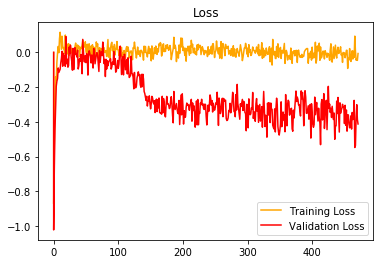

In [29]:
machine.show_loss()


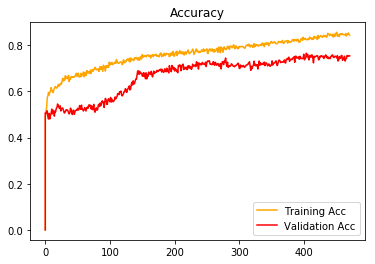

In [30]:
machine.show_acc()